# Causal Inference 

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("my_survey.csv") 
print(df.head())

   Age  Gender         Country self_employed family_history treatment  \
0   37  Female   United States            No             No       Yes   
1   44    Male   United States            No             No        No   
2   32    Male          Canada            No             No        No   
3   31    Male  United Kingdom            No            Yes       Yes   
4   31    Male   United States            No             No        No   

  work_interfere remote_work tech_company    benefits  ...   seek_help  \
0          Often          No          Yes         Yes  ...         Yes   
1         Rarely          No           No  Don't know  ...  Don't know   
2         Rarely          No          Yes          No  ...          No   
3          Often          No          Yes          No  ...          No   
4          Never         Yes          Yes         Yes  ...  Don't know   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy                    

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1251 non-null   int64 
 1   Gender                     1251 non-null   object
 2   Country                    1251 non-null   object
 3   self_employed              1251 non-null   object
 4   family_history             1251 non-null   object
 5   treatment                  1251 non-null   object
 6   work_interfere             1251 non-null   object
 7   remote_work                1251 non-null   object
 8   tech_company               1251 non-null   object
 9   benefits                   1251 non-null   object
 10  care_options               1251 non-null   object
 11  wellness_program           1251 non-null   object
 12  seek_help                  1251 non-null   object
 13  leave                      1251 non-null   object
 14  mental_h

In [7]:
df.isnull().sum()

Age                          0
Gender                       0
Country                      0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64

The code below is to identify rare categories (those that make up less than 1% of the data) within a list of categorical columns, then make those <0.01 as "Other".

In [10]:
for col in ['Gender','Country','self_employed','family_history','work_interfere','remote_work','tech_company','benefits','care_options',
            'wellness_program','seek_help','leave','mental_health_consequence','phys_health_consequence','coworkers','supervisor',
            'mental_health_interview','phys_health_interview','mental_vs_physical','obs_consequence']:
    vc = df[col].value_counts(normalize=True)
    rare = vc[vc < 0.01]
    if not rare.empty:
        print(f"These categories account for less than 1% of the total in {col}：\n", rare)

These categories account for less than 1% of the total in Country：
 Country
India                     0.007994
New Zealand               0.006395
Italy                     0.005596
Poland                    0.005596
Sweden                    0.005596
Switzerland               0.005596
South Africa              0.004796
Belgium                   0.004796
Brazil                    0.004796
Israel                    0.003997
Singapore                 0.003197
Bulgaria                  0.003197
Mexico                    0.002398
Russia                    0.002398
Finland                   0.002398
Austria                   0.002398
Denmark                   0.001599
Greece                    0.001599
Portugal                  0.001599
Colombia                  0.001599
Croatia                   0.001599
Moldova                   0.000799
Georgia                   0.000799
China                     0.000799
Thailand                  0.000799
Czech Republic            0.000799
Norway        

In [12]:
vc = df['Country'].value_counts(normalize=True)
rare_labels = vc[vc < 0.01].index.tolist()
df['Country_grouped'] = df['Country'].replace(rare_labels, 'Other')

In [14]:
df = df.drop(columns=['Country']) 

In [16]:
df.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,remote_work,tech_company,benefits,care_options,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Country_grouped
0,37,Female,No,No,Yes,Often,No,Yes,Yes,Not sure,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,United States
1,44,Male,No,No,No,Rarely,No,No,Don't know,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,United States
2,32,Male,No,No,No,Rarely,No,Yes,No,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,Canada
3,31,Male,No,Yes,Yes,Often,No,Yes,No,Yes,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,United Kingdom
4,31,Male,No,No,No,Never,Yes,Yes,Yes,No,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,United States


Step 1: Examine Value Distributions of Categorical Variables

Before selecting treatment variables for causal inference, we first examine the distribution of values in each categorical column. This helps us understand:

- Whether a variable is balanced or imbalanced (e.g., dominated by one class)
- If a variable is suitable for use as a binary treatment
- How many unique levels a categorical variable has (e.g., Yes/No, or multi-level like "Never", "Sometimes", etc.)

In [19]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    print(f"---- {col} ----")
    print(df[col].value_counts(normalize=True), "\n")


---- Gender ----
Gender
Male      0.785771
Female    0.197442
Other     0.016787
Name: proportion, dtype: float64 

---- self_employed ----
self_employed
No     0.886491
Yes    0.113509
Name: proportion, dtype: float64 

---- family_history ----
family_history
No     0.609113
Yes    0.390887
Name: proportion, dtype: float64 

---- treatment ----
treatment
Yes    0.505196
No     0.494804
Name: proportion, dtype: float64 

---- work_interfere ----
work_interfere
Sometimes         0.370903
Not applicable    0.209432
Never             0.169464
Rarely            0.138289
Often             0.111910
Name: proportion, dtype: float64 

---- remote_work ----
remote_work
No     0.703437
Yes    0.296563
Name: proportion, dtype: float64 

---- tech_company ----
tech_company
Yes    0.819345
No     0.180655
Name: proportion, dtype: float64 

---- benefits ----
benefits
Yes           0.378098
Don't know    0.325340
No            0.296563
Name: proportion, dtype: float64 

---- care_options ----
care_o

After reviewing the distributions, we choose four variables to use as treatments for separate causal inference analyses:
1. benefits: Whether the company offers mental health benefits
2. remote_work: Whether the employee is allowed to work remotely
3. self_employed: Whether the respondent is self-employed
4. tech_company: Whether the respondent works in a tech company

These variables are selected based on the following criteria:
- Interpretability: They reflect real-world, actionable workplace or employment conditions.
- Intervenability: They represent aspects that can be changed or influenced by employers or policymakers.
- Distributive Balance: Although some are imbalanced (e.g., self_employed), they are still usable with techniques such as propensity score weighting or ATT estimation.

In [22]:
treatments = ['benefits', 'remote_work', 'self_employed', 'tech_company']

for col in treatments:
    print(f"---- {col} ----")
    print(df[col].value_counts(normalize=True), "\n")


---- benefits ----
benefits
Yes           0.378098
Don't know    0.325340
No            0.296563
Name: proportion, dtype: float64 

---- remote_work ----
remote_work
No     0.703437
Yes    0.296563
Name: proportion, dtype: float64 

---- self_employed ----
self_employed
No     0.886491
Yes    0.113509
Name: proportion, dtype: float64 

---- tech_company ----
tech_company
Yes    0.819345
No     0.180655
Name: proportion, dtype: float64 



### Categorical to Numerical

In [25]:
from sklearn.preprocessing import LabelEncoder

In [27]:
df['benefits_binary'] = df['benefits'].apply(lambda x: 1 if x == 'Yes' else 0)

In [29]:
df = df.drop(columns=['benefits']) 

In [31]:
df_encoded = df.copy()

for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        unique_vals = df_encoded[col].nunique()
        
        if unique_vals == 2:
            df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
        else:
            df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=False)


In [33]:
df_encoded.head()

,Age,self_employed,family_history,treatment,remote_work,tech_company,obs_consequence,benefits_binary,Gender_Female,Gender_Male,...,mental_vs_physical_Yes,Country_grouped_Australia,Country_grouped_Canada,Country_grouped_France,Country_grouped_Germany,Country_grouped_Ireland,Country_grouped_Netherlands,Country_grouped_Other,Country_grouped_United Kingdom,Country_grouped_United States
0,37,0,0,1,0,1,0,1,True,False,...,True,False,False,False,False,False,False,False,False,True
1,44,0,0,0,0,0,0,0,False,True,...,False,False,False,False,False,False,False,False,False,True
2,32,0,0,0,0,1,0,0,False,True,...,False,False,True,False,False,False,False,False,False,False
3,31,0,1,1,0,1,1,0,False,True,...,False,False,False,False,False,False,False,False,True,False
4,31,0,0,0,1,1,0,1,False,True,...,False,False,False,False,False,False,False,False,False,True


In [35]:
df_encoded.to_csv("encoded_dataset.csv",             
                  index=False,                       
                  encoding="utf-8")                  


### Pipeline

In [106]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from causalml.inference.meta import BaseTRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError


In [107]:
def calculate_e_value(estimate, se):
    z = abs(estimate / se)
    rr = np.exp(z)
    e_value = rr + np.sqrt(rr * (rr - 1))
    return round(e_value, 3)

In [108]:
def check_balance(df, treatment_col, outcome_col):
    T = df[treatment_col]
    X = df.drop(columns=[treatment_col, outcome_col])
    model = LogisticRegression(max_iter=1000)
    model.fit(X, T)
    ps = model.predict_proba(X)[:, 1]

    sns.kdeplot(ps[T==1], label='Treated', fill=True)
    sns.kdeplot(ps[T==0], label='Control', fill=True)
    plt.title(f'Propensity Score: {treatment_col}')
    plt.legend()
    plt.show()

In [109]:
def run_causalml_pipeline(df, treatment_col, outcome_col):
    T = df[treatment_col].values
    Y = df[outcome_col].values
    X = df.drop(columns=[treatment_col, outcome_col]).values
    X_df = df.drop(columns=[treatment_col, outcome_col])  

    print(f"\n=== Treatment: {treatment_col} ===")
    print("Treatment distribution:")
    print(pd.Series(T).value_counts(normalize=True))

    imbalance_ratio = T.sum() / len(T)
    print(f"Imbalance ratio (treated proportion): {imbalance_ratio:.2f}")
    if imbalance_ratio < 0.2 or imbalance_ratio > 0.8:
        print("Warning: Severe treatment imbalance detected. Consider reweighting or undersampling.")


    # T-Learner
    learner = BaseTRegressor(learner=RandomForestRegressor(max_depth=5), control_name=0)
    # PS model + IPW weights
    ps_model = LogisticRegression(max_iter=1000)
    ps_model.fit(X_df, T)
    ps = ps_model.predict_proba(X_df)[:, 1]
    ps = np.clip(ps, 0.05, 0.95)  
    weights = T / ps + (1 - T) / (1 - ps)

    # Learner with weights
    learner.fit(X=X_df.values, treatment=T, y=Y, p=ps)

    # ATE
    ate, lb, ub = learner.estimate_ate(X=X, treatment=T, y=Y)
    ate = ate.item()
    lb = lb.item()
    ub = ub.item()

    # E-value
    se = (ub - lb) / (2 * 1.96) 
    e_val = calculate_e_value(ate, se)
    print(f"ATE: {ate:.4f}, 95% CI: ({lb:.4f}, {ub:.4f})")
    print(f"E-value: {e_val}")

    return {
        'treatment': treatment_col,
        'ate': ate,
        'ci_lower': lb,
        'ci_upper': ub,
        'e_value': e_val
    }
    

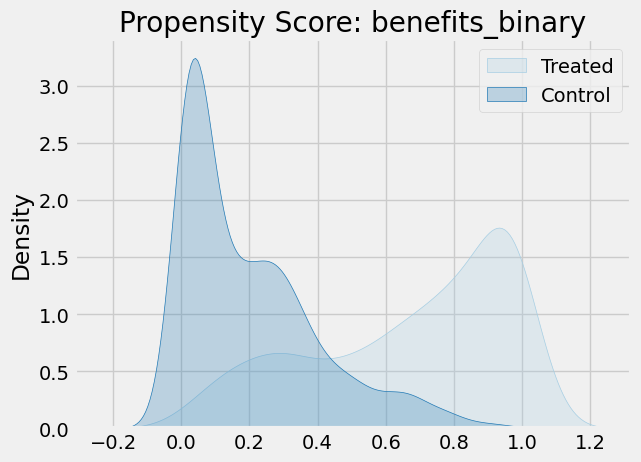


=== Treatment: benefits_binary ===
Treatment distribution:
0    0.621902
1    0.378098
Name: proportion, dtype: float64
Imbalance ratio (treated proportion): 0.38


D:\anaconda3\envs\causal_env\lib\site-packages\causalml\metrics\regression.py:50: RuntimeWarning: invalid value encountered in divide
  return 2.0 * np.mean(np.abs(y - p) / (np.abs(y) + np.abs(p)))


ATE: 0.0925, 95% CI: (0.0580, 0.1270)
E-value: 381.508


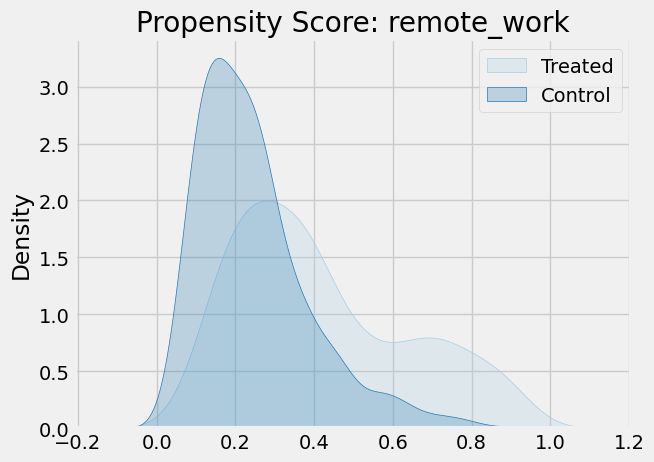


=== Treatment: remote_work ===
Treatment distribution:
0    0.703437
1    0.296563
Name: proportion, dtype: float64
Imbalance ratio (treated proportion): 0.30


D:\anaconda3\envs\causal_env\lib\site-packages\causalml\metrics\regression.py:50: RuntimeWarning: invalid value encountered in divide
  return 2.0 * np.mean(np.abs(y - p) / (np.abs(y) + np.abs(p)))


ATE: -0.0100, 95% CI: (-0.0474, 0.0273)
E-value: 2.772


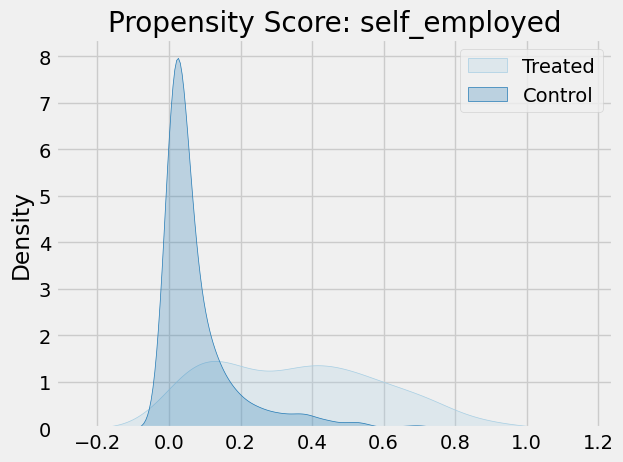


=== Treatment: self_employed ===
Treatment distribution:
0    0.886491
1    0.113509
Name: proportion, dtype: float64
Imbalance ratio (treated proportion): 0.11


D:\anaconda3\envs\causal_env\lib\site-packages\causalml\metrics\regression.py:50: RuntimeWarning: invalid value encountered in divide
  return 2.0 * np.mean(np.abs(y - p) / (np.abs(y) + np.abs(p)))


ATE: -0.0235, 95% CI: (-0.0726, 0.0256)
E-value: 4.554


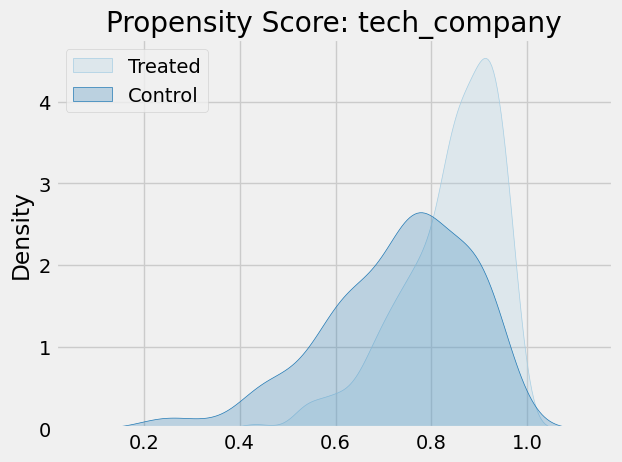


=== Treatment: tech_company ===
Treatment distribution:
1    0.819345
0    0.180655
Name: proportion, dtype: float64
Imbalance ratio (treated proportion): 0.82
ATE: -0.0029, 95% CI: (-0.0419, 0.0362)
E-value: 1.58

=== Summary of ATE & E-values ===
         treatment       ate  ci_lower  ci_upper  e_value
0  benefits_binary  0.092474  0.057965  0.126982  381.508
1      remote_work -0.010011 -0.047352  0.027330    2.772
2    self_employed -0.023514 -0.072582  0.025555    4.554
3     tech_company -0.002886 -0.041930  0.036159    1.580


D:\anaconda3\envs\causal_env\lib\site-packages\causalml\metrics\regression.py:50: RuntimeWarning: invalid value encountered in divide
  return 2.0 * np.mean(np.abs(y - p) / (np.abs(y) + np.abs(p)))


In [110]:
treatment_list = ['benefits_binary', 'remote_work', 'self_employed', 'tech_company']
outcome_col = 'treatment'
results = []

for treatment_col in treatment_list:
    #check balance
    check_balance(df_encoded, treatment_col, outcome_col)

    # causal inference
    result = run_causalml_pipeline(df_encoded, treatment_col, outcome_col)
    results.append(result)


results_df = pd.DataFrame(results)
print("\n=== Summary of ATE & E-values ===")
print(results_df)

## Objective

This analysis investigates the causal impact of four binary treatment variables on employees' likelihood of actively seeking mental health support (`outcome = treatment`).  
Applying the **T-Learner** method with **Inverse Probability Weighting (IPW)** based on estimated propensity scores.

---

## Treatment Variables

- `benefits_binary`: Whether the company provides mental health benefits.
- `remote_work`: Whether remote work is allowed.
- `self_employed`: Whether the respondent is self-employed.
- `tech_company`: Whether the respondent works in a tech company.

---

## Summary of ATE, Confidence Intervals, and E-values

| Treatment         | ATE     | 95% Confidence Interval | E-value | Imbalance Ratio | Balance Status |
|------------------|---------|--------------------------|---------|------------------|----------------|
| `benefits_binary`| 0.0925  | (0.0580, 0.1270)         | 381.508  | 0.38             |  Balanced     |
| `remote_work`    | -0.0100 | (-0.0474, 0.0273)        | 2.772    | 0.30             |  Balanced     |
| `self_employed`  | -0.0235 | (-0.0726, 0.0256)        | 4.554    | 0.11             |  Imbalanced   |
| `tech_company`   | -0.0029 | (-0.0419, 0.0362)        | 1.580    | 0.82             |  Imbalanced   |

---

##  Interpretations & Insights

###  `benefits_binary` – Mental Health Benefits

- **ATE = 0.0925** with a positive and statistically significant confidence interval.
- Suggests that providing mental health benefits increases the probability of employees seeking help by approximately **9.25%**.
- **E-value = 381.508**, indicating extreme robustness even in the presence of unmeasured confounding.
- **Propensity scores are well balanced**, supporting reliable inference.

This is the **most robust and actionable insight** of the analysis and should be highlighted in any reporting.

---

###  `remote_work` – Remote Work Policy

- **ATE is small (-0.0100)** and the confidence interval crosses zero, indicating **no significant causal effect**.
- **E-value = 2.772** shows modest robustness.
- The treated and control groups are **reasonably balanced**, suggesting this result is statistically valid but **practically inconclusive**.

Remote work alone does not show a clear impact on mental health help-seeking in this dataset.

---

###  `self_employed` – Self-Employment Status

- **ATE is negative and insignificant (-0.0235)**.
- **Imbalance ratio = 0.11**, meaning only ~11% of the sample is self-employed.
- Severe lack of overlap in propensity score distributions makes the estimation **unstable** despite IPW adjustment.

This result is **not reliable** due to extreme imbalance. Interpret with caution or exclude from key conclusions.

---

###  `tech_company` – Working in Tech Industry

- **ATE = -0.0029**, not statistically significant.
- **Imbalance ratio = 0.82**, indicating strong skew toward tech workers.
- Partial overlap in propensity scores, but **limited support for reliable inference**.

Similar to `self_employed`, imbalance weakens causal interpretation. Results should be treated as exploratory.

---

##  Overall Takeaways

-  The most **actionable and statistically significant** treatment is `benefits_binary`, highlighting the **positive impact of offering mental health support programs**.
-  `remote_work` does not show a clear effect but is methodologically sound.
-  Both `self_employed` and `tech_company` suffer from **severe imbalance**, which limits the credibility of any causal claims despite adjustment techniques.




### Treatment = benefits_binary

In [111]:
print("---- benefits_binary ----")
print(df_encoded['benefits_binary'].value_counts(normalize=True), "\n")

---- benefits_binary ----
benefits_binary
0    0.621902
1    0.378098
Name: proportion, dtype: float64 



In [135]:
import pandas as pd
import numpy as np
from causalml.inference.meta import BaseTClassifier
from causalml.metrics import classification_metrics
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

In [137]:

T_col = "benefits_binary"
Y_col = "treatment"

X_df = df_encoded.drop(columns=[T_col, Y_col])
T    = df_encoded[T_col].values
Y    = df_encoded[Y_col].values



In [139]:

def _wtd_mean_std(x, w):
    mu = np.average(x, weights=w)
    var = np.average((x - mu) ** 2, weights=w)
    return mu, np.sqrt(var)

def compute_smd_table(X, T, w):
    smd_raw, smd_wtd = {}, {}
    
    treat_idx = T == 1
    ctrl_idx  = T == 0
    
    for col in X.columns:
        x  = X[col].values.astype(float)
        
        
        mu_t, sd_t = x[treat_idx].mean(), x[treat_idx].std(ddof=0)
        mu_c, sd_c = x[ctrl_idx].mean(), x[ctrl_idx].std(ddof=0)
        pooled_sd  = np.sqrt((sd_t**2 + sd_c**2) / 2)
        smd_raw[col] = 0 if pooled_sd == 0 else (mu_t - mu_c) / pooled_sd
        
        
        mu_t_w, sd_t_w = _wtd_mean_std(x[treat_idx], w[treat_idx])
        mu_c_w, sd_c_w = _wtd_mean_std(x[ctrl_idx],  w[ctrl_idx])
        pooled_sd_w    = np.sqrt((sd_t_w**2 + sd_c_w**2) / 2)
        smd_wtd[col]   = 0 if pooled_sd_w == 0 else (mu_t_w - mu_c_w) / pooled_sd_w
    
    smd_df = (pd.DataFrame({
                "SMD_before": smd_raw,
                "SMD_after":  smd_wtd
             })
             .assign(Abs_after=lambda d: d.SMD_after.abs())
             .sort_values("Abs_after", ascending=False))
    
    return smd_df


In [140]:
smd_table = compute_smd_table(X_df, T, w)
print(smd_table.head(15))          
print((smd_table.Abs_after < 0.1).mean())



                                SMD_before  SMD_after  Abs_after
care_options_Yes                  0.952223   0.336498   0.336498
Country_grouped_United States     0.874707   0.301709   0.301709
care_options_No                  -0.738052  -0.268814   0.268814
Country_grouped_United Kingdom   -0.523980  -0.258385   0.258385
seek_help_Yes                     0.954637   0.251720   0.251720
wellness_program_Yes              0.856781   0.229075   0.229075
mental_vs_physical_Yes            0.211268   0.195235   0.195235
Country_grouped_Ireland          -0.182153  -0.191092   0.191092
seek_help_No                     -0.710890  -0.179297   0.179297
wellness_program_No              -0.713502  -0.175205   0.175205
Country_grouped_Australia        -0.109806  -0.140577   0.140577
Country_grouped_Other            -0.423021  -0.138018   0.138018
mental_vs_physical_Don't know    -0.116513  -0.123903   0.123903
Country_grouped_Canada            0.025786   0.094928   0.094928
Gender_Male              

In [145]:
from causalml.inference.meta import BaseTClassifier
from xgboost import XGBClassifier
import shap, matplotlib.pyplot as plt, pandas as pd

base = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

learner = BaseTClassifier(
    learner=base,
    control_learner=base,
    treatment_learner=base
)


learner.fit(X=X_df, treatment=T, y=Y, p=ps)

ate, lb, ub = learner.estimate_ate(X=X_df, treatment=T, y=Y, p=ps)
print(f"ATE = {ate[0]:.4f}   95% CI [{lb[0]:.4f}, {ub[0]:.4f}]")



ATE = 0.0753   95% CI [0.0464, 0.1042]


## Covariate Balance Check (Post-IPW)

After applying Inverse Probability Weighting (IPW) for `benefits_binary`, the covariate balance was evaluated using Standardized Mean Differences (SMD):

- Approximately **77.6%** of features achieved an absolute SMD < 0.1 after weighting.
- Some features, such as `care_options_Yes` and `Country_grouped_United States`, still exhibit moderate imbalance (SMD ≈ 0.25–0.33).
- Overall, balance improvement is substantial, but minor residual imbalance remains.


---

## Alternative Model: XGBoost-based T-Learner

To validate robustness, an XGBoost classifier was used as the base learner in a T-Learner framework.

- **ATE = 0.0753**
- **95% Confidence Interval: [0.0464, 0.1042]**

The causal effect remains **positive and statistically significant**, consistent with earlier estimates using Random Forests.  
This reinforces the conclusion that **providing mental health benefits increases employees' likelihood of seeking support** by approximately **7.5%**.

---

## Summary of Additional Validation

| Aspect                  | Result                         |
|--------------------------|--------------------------------|
| Covariate Balance        | 77.6% features balanced (<0.1 SMD) |
| Alternative Model (XGB)  | Positive, significant ATE (7.5%) |
| Robustness               | Consistent direction across models |

---



# Treatment = benefits_binary

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [152]:
X = df_encoded.drop(columns=['benefits_binary', "treatment"]) 
y = df_encoded['treatment']  
w = df_encoded["benefits_binary"] 



In [153]:
plt.style.use('fivethirtyeight')

In [154]:
model_tau = LGBMRegressor(importance_type='gain')  

In [155]:
base_algo = LGBMRegressor()

slearner = BaseSRegressor(base_algo, control_name=0)
slearner.estimate_ate(X, w, y)

  File "D:\anaconda3\envs\causal_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "D:\anaconda3\envs\causal_env\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "D:\anaconda3\envs\causal_env\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\anaconda3\envs\causal_env\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1251, number of used features: 58
[LightGBM] [Info] Start training from score 0.505196


array([0.0652])

In [156]:
slearner_tau = slearner.fit_predict(X, w, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 1251, number of used features: 58
[LightGBM] [Info] Start training from score 0.505196


In [157]:
feature_names = X.columns.tolist()
feature_names

['Age',
 'self_employed',
 'family_history',
 'remote_work',
 'tech_company',
 'obs_consequence',
 'Gender_Female',
 'Gender_Male',
 'Gender_Other',
 'work_interfere_Never',
 'work_interfere_Not applicable',
 'work_interfere_Often',
 'work_interfere_Rarely',
 'work_interfere_Sometimes',
 'care_options_No',
 'care_options_Not sure',
 'care_options_Yes',
 "wellness_program_Don't know",
 'wellness_program_No',
 'wellness_program_Yes',
 "seek_help_Don't know",
 'seek_help_No',
 'seek_help_Yes',
 "leave_Don't know",
 'leave_Somewhat difficult',
 'leave_Somewhat easy',
 'leave_Very difficult',
 'leave_Very easy',
 'mental_health_consequence_Maybe',
 'mental_health_consequence_No',
 'mental_health_consequence_Yes',
 'phys_health_consequence_Maybe',
 'phys_health_consequence_No',
 'phys_health_consequence_Yes',
 'coworkers_No',
 'coworkers_Some of them',
 'coworkers_Yes',
 'supervisor_No',
 'supervisor_Some of them',
 'supervisor_Yes',
 'mental_health_interview_Maybe',
 'mental_health_intervie

In [158]:
slearner.get_importance(X=X,
                        tau=slearner_tau,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Age                                0.111616
 family_history                     0.105903
 work_interfere_Never               0.102833
 Gender_Female                      0.086710
 work_interfere_Not applicable      0.082493
 work_interfere_Rarely              0.044591
 work_interfere_Sometimes           0.044414
 seek_help_No                       0.038080
 Country_grouped_United Kingdom     0.033192
 wellness_program_Yes               0.029552
 care_options_Yes                   0.023035
 coworkers_No                       0.022612
 Country_grouped_United States      0.021434
 supervisor_No                      0.017972
 phys_health_consequence_No         0.013777
 mental_vs_physical_Don't know      0.013761
 care_options_Not sure              0.012467
 leave_Somewhat easy                0.012333
 phys_health_interview_Maybe        0.011874
 Country_grouped_Canada             0.011258
 remote_work                        0.010895
 phys_health_consequence_Maybe      0.010792
 leave_

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

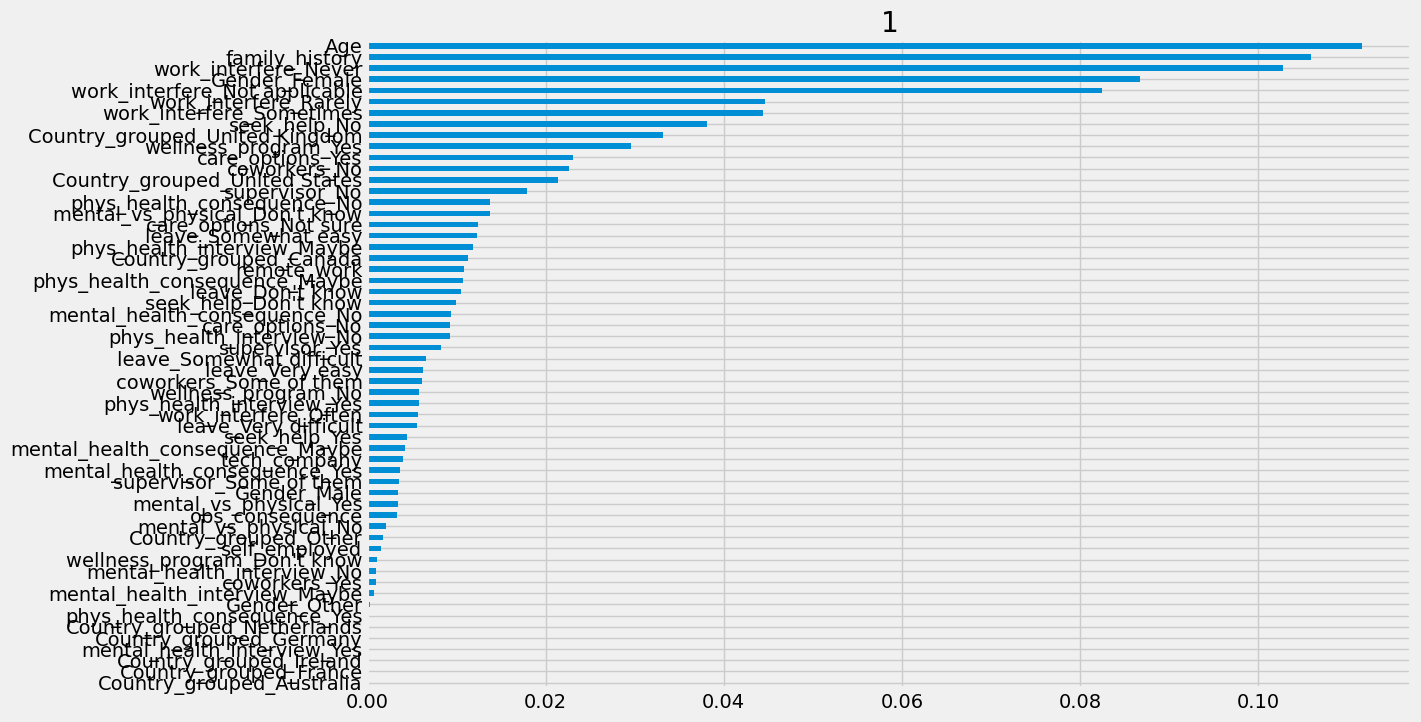

In [163]:
slearner.plot_importance(X=X,
                         tau=slearner_tau,
                         normalize=True,
                         method='auto',
                         features=feature_names)

# Feature Importance Analysis from Causal Inference Model

## 1. Observation by Feature Importance

### Top Features
- `Age`
- `family_history`
- `work_interfere_Never`
- `Gender_Female`
- `work_interfere_Not applicable`
- `work_interfere_Sometimes`

### Key Observations
- **Gender Differences Emerge**  
 `Gender_Female` appears as one of the top-ranked features, even surpassing several workplace environment factors.  
This suggests that demographic gender differences significantly shape employees' responsiveness to mental health benefit offerings.  
Female employees may exhibit distinct patterns of help-seeking behaviour when mental health support is made available.

- **Psychological Risk Factors Dominate**  
  `family_history` and multiple `work_interfere_*` features show very high importance scores, indicating that employees' mental health risk indicators are central to the model's decision process.
  
- **Demographics Matter**  
  `Age` is the single most important feature, surpassing even direct psychological indicators.

- **Geographical Variations**  
  Country-specific variables such as `Country_grouped_United Kingdom` and `Country_grouped_Canada` are important, but ranked lower than individual psychological and demographic variables.

- **Company Support Indicators**  
  Features such as `wellness_program_Yes`, `coworkers_No`, and `seek_help_No` contribute meaningfully to the treatment prediction, indicating that organisational culture plays a secondary but notable role.

---

## 2. Business Insights

| Insight Category | Insight | Implication |
|:---|:---|:---|
| **Age is the primary driver** | Age has the highest feature importance. | Mental health policies should be segmented by age group, recognising that age significantly influences perceived need or allocation decisions. |
| **Mental health risk indicators matter most** | Features like `family_history` and `work_interfere_*` are heavily weighted. | Companies prioritise visible psychological risks when allocating benefits; programs should aim at early detection and support. |
| **Geographical disparities exist** | Country-level features (e.g., UK, Canada) impact benefit distribution but are less influential than personal and workplace factors. | Regional HR policies must adapt to local employee expectations and practices, but internal company culture carries more weight. |
| **Company wellness culture plays a secondary but meaningful role** | Organisational features like wellness programs and coworker support affect benefit allocation. | Strengthening internal mental health support structures can improve benefit distribution equity and reach. |

---

## 3. Final Summary

The feature importance results reveal that **employee demographics, female and psychological risk indicators dominate the decision-making process for mental health benefit allocation**, far outweighing geographic or organisational factors.  
Age, mental health history, and workplace mental health interference are the critical variables.




In [164]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 0.01962652,  0.00050178,  0.0297106 , ..., -0.00014486,
          0.00410288, -0.0022454 ],
        [-0.00384852,  0.00138626,  0.0269708 , ..., -0.00061268,
          0.00383913, -0.00243072],
        [ 0.01297138,  0.00131285,  0.04808526, ..., -0.0003058 ,
          0.0096186 ,  0.00713786],
        ...,
        [ 0.01059239,  0.00090752, -0.05064106, ..., -0.00031965,
          0.00320104, -0.00489338],
        [ 0.00633513,  0.00074951,  0.00739288, ...,  0.00019077,
          0.00190012, -0.00285   ],
        [ 0.01556934,  0.0013035 , -0.03429175, ..., -0.00050016,
          0.00269887, -0.00349052]])}

In [165]:
np.mean(np.abs(shap_slearner[1]), axis=0)


array([1.28051320e-02, 1.72785816e-03, 3.05978429e-02, 4.43602854e-03,
       2.36729345e-03, 2.45111559e-03, 1.96634320e-02, 9.74094526e-04,
       3.02919046e-04, 1.04887184e-02, 1.34685075e-02, 2.06885842e-03,
       1.17197945e-02, 1.40661665e-02, 1.75177007e-03, 4.88901485e-03,
       4.99194397e-03, 9.76018052e-04, 1.69306661e-03, 1.06651127e-02,
       3.93593725e-03, 8.73519864e-03, 1.18845902e-03, 1.22337076e-03,
       2.49877661e-03, 5.01378525e-03, 1.35565330e-03, 1.49819622e-03,
       9.76096184e-04, 1.55279097e-03, 2.09576815e-03, 3.81603473e-03,
       3.83056557e-03, 1.67238990e-04, 7.06103067e-03, 1.24939519e-03,
       6.05582902e-04, 1.87445485e-03, 8.94644996e-04, 1.76256926e-03,
       5.43229298e-04, 2.61823091e-04, 6.16612664e-05, 3.99374350e-03,
       2.18875349e-03, 2.06772667e-03, 2.19459125e-03, 7.10251137e-04,
       1.40189635e-03, 0.00000000e+00, 4.11256118e-03, 0.00000000e+00,
       3.98710490e-05, 3.47444613e-05, 2.06681527e-04, 6.11614479e-04,
      

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

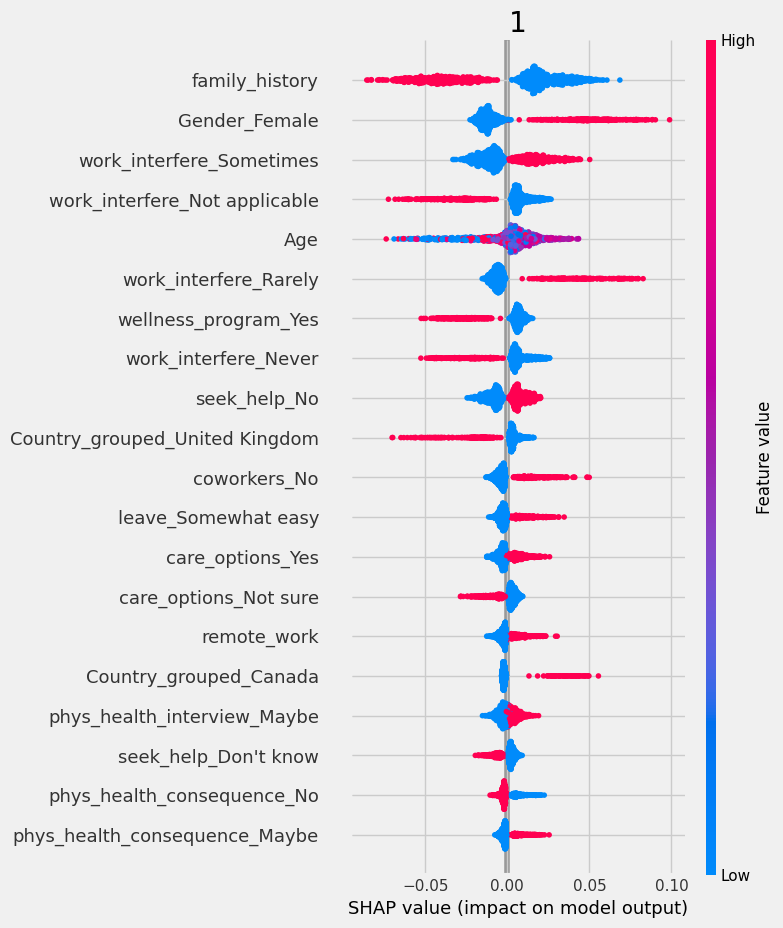

In [166]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

## Feature Importance and SHAP Analysis for Treatment Effect (`benefits_binary`)

### 1. Objective

After estimating the causal impact of providing mental health benefits (`benefits_binary`) on employees' likelihood of seeking treatment, we further explore **which employee characteristics drive the heterogeneity of the treatment effect**.

A Base S-Learner model with LightGBM was applied to model the Conditional Average Treatment Effect (τ(x)).  
Feature importance was assessed using two complementary approaches:
- **Model-based Feature Importance** (Gain-based)
- **SHAP Values** (Model-agnostic Interpretability)

---

### 2. Model Setup

- **Base Learner**: LightGBM Regressor
- **Method**: S-Learner (single model predicting τ(x))
- **Inputs**: All covariates except `benefits_binary` and `treatment`
- **Target**: Treatment outcome (`treatment`)
- **Sample Weights**: Treatment assignment (`benefits_binary`)

---

### 3. Results: Feature Importance (Gain-Based Ranking)

The top features contributing to explaining the treatment effect include:

| Feature | Importance Score |
|:--------|:-----------------|
| Age | 0.1116 |
| Family History | 0.1059 |
| Work Interference (Never) | 0.1028 |
| Gender (Female) | 0.0867 |
| Work Interference (Not Applicable) | 0.0824 |
| Work Interference (Rarely) | 0.0446 |
| Work Interference (Sometimes) | 0.0444 |
| Seek Help (No) | 0.0381 |
| ... | ... |

#### 🔹 Observations:
- **Age** and **Family History** are the two most influential variables.
- **Work Interference patterns** (Never, Rarely, Sometimes) appear repeatedly among the top features.
- **Gender (Female)** ranks high, suggesting possible gender-driven heterogeneity.
- **Help-seeking behaviour** (seek_help) is also predictive of treatment effect.

#### 🔹 Interpretation:
- These features are **strongly associated with how much employees benefit from having mental health programs**.
- Workplace environment and prior mental health experiences significantly modulate treatment responses.


# FINAL MARKDOWN:

# Comprehensive SHAP Value Analysis

## 1. Observation by Feature

### 1.1 `family_history`
- **SHAP distribution**: High feature value (having a family history of mental health issues, shown in red) is associated with **negative SHAP values** (shifted left).
- **Interpretation**:  
  Employees with a family history of mental illness are **less likely** to be offered mental health benefits. Because they are more likely to seek help regardless of whether benefits are offered.
- Thus, the **marginal improvement** from providing mental health benefits is smaller for this group compared to others.

---

### 1.2 `work_interfere_Sometimes`
- **SHAP distribution**: High feature value (reporting occasional work interference, shown in red) is associated with **positive SHAP values** (shifted right).
- **Interpretation**:  
  Employees experiencing occasional work-related mental health interference are **more likely** to receive benefits.

---

### 1.3 `work_interfere_Not applicable`
- **SHAP distribution**: High feature value (work interference not applicable, shown in red) is associated with **negative SHAP values** (shifted left).
- **Interpretation**:  
  Employees for whom work interference is "not applicable" (likely not in standard employment) are **less likely** to receive mental health benefits.

---

### 1.4 `Gender_Female`
- **SHAP distribution**: High feature value (being female, shown in red) is generally associated with **positive SHAP values**.
- **Interpretation**:  
  Female employees are **more likely** to be provided with mental health benefits compared to male employees.

---

### 1.5 `Age`
- **SHAP distribution**: Both high and low feature values (red and blue) are scattered across positive and negative SHAP values.
- **Interpretation**:  
  The relationship between age and benefit allocation is **non-linear**:
  - Younger and older employees are more associated with receiving benefits.
  - Middle-aged employees show a more neutral association.

> **Real-world Highlight**:  
> Some features (such as Age) display non-linear effects, meaning the relationship with the outcome is not simply "higher is better" or "lower is better."  
> Instead, complex patterns like U-shaped effects may occur, reflected by red and blue points on both sides of SHAP value plots.

---

### 1.6 Geographic Variations
- **Country_grouped_United_Kingdom**
  - High feature value (being located in the UK) is associated with **negative SHAP values**.
  - **Interpretation**: Employees based in the UK are **less likely** to receive mental health benefits compared to non-UK employees.

- **Country_grouped_Canada**
  - High feature value (being located in Canada) shows a **weaker but noticeable positive influence** on benefit allocation.
  - **Interpretation**: Canadian employees have a **slightly higher likelihood** of receiving benefits compared to other countries.

---

## 2. Cross-feature Summary

- **Psychological Risk and Work Interference**:
  - Employees with visible psychological risk factors (occasional work interference) are more likely to be supported.
  - Employees with deeper background risk (family history) are paradoxically **less likely** to be supported.

- **Demographics**:
  - **Gender** and **Age** significantly influence benefit allocation.
  - Female and younger/older employees are relatively favoured.

- **Organisational Factors**:
  - Presence of wellness programs and perceived support significantly impact the probability of receiving benefits.

- **Geographical Differences**:
  - Unexpected negative impact for UK employees highlights regional practice differences.

---

## 3. Business Insights and Recommendations

| Theme | Insight | Recommendation |
|:---|:---|:---|
| **Support Gaps for At-Risk Employees** | Employees with a family history are underserved. | Develop targeted initiatives for employees with historical psychological risks. |
| **Proactive Mental Health Monitoring** | Work interference triggers support allocation. | Implement early detection tools for mental stress. |
| **Gender and Age Inclusivity** | Benefit allocation favours women and younger/older employees. | Ensure fair access across genders and all age groups. |
| **Geographic Customisation** | Regional disparities exist, particularly in the UK. | Update HR policies to maintain consistent mental health support across regions. |
| **Address Non-linear Effects** | Age impacts are complex and non-linear. | Tailor mental health programs by career stage. |

---

# Final Summary

Mental health benefit allocation is influenced by psychological, demographic, organisational, and geographical factors.  
Patterns are sometimes non-intuitive, with underserved high-risk groups and regional disparities.  
Organisations should adopt a **data-driven, differentiated strategy** to improve mental health support effectiveness.
